an implementation of a SAR data generation simulator using the phase-based approach described in:

https://ieeexplore.ieee.org/document/10106365


essentially, a scene is described as a superposition of targets. for a given measurement, the ADC return, as a function of time and position, can be described as:

$ y_{ADC,m}(t) = \sum a_m cos (\beta_{IF, r_j,m} + \omega_{IF, r_j,m} * t) $

for given values of (m): antenna position, (j): target.

the amplitude of a target (a) can be calculated using the basic radar range equation, and normalized into ADC space

the constant-phase term representing the return from a target can be defined as:

$ \beta_{IF, r} = 2 \pi f_1 \Delta t(r) - \pi u \Delta t^2(r) $

where (u) is the "ramp factor" (gamma) of the radar

$ u = (f_2 - f_1) / T $

and t(r) is the solution of the time offset for a given target range

$ \Delta t(r) = 2 r / c $

finally, the frequency term can be represented as

$ \omega_{IF, r} = 2 \pi u \Delta t(r) $

these equations provide an easy-to-compute time-domain closed-form solution for the ADC input as a function of various target parameters.

the below sections will implement the above equations and attempt to generate SAR "range-compressed" plots (range FFT output as a function of time).


the only remaining trick is defining a power function that will be used. the base radar equation is detailed below:

$ P_r = \frac{P_t G_t G_r \lambda^2 \sigma}{(4 \pi)^3 R^4 L} $

(no system losses will be modeled in this implementation, as they just represent a fixed offset to the data)

the tricky terms to deal with are the gains.
a general approach would be nice, but the math to compute it is impossible to generalize without knowledge of the antenna array in question.
the antenna patterns from the AWR2243BOOST are instead functionally approximated and hard-coded.

using the AWR2243 transciever by Texas Instruments (datasheet here: https://www.ti.com/product/AWR2243), some of the other critical parameters can be recovered.

f_1 and f_2 are 76GHz, and 81GHz, respectively.
the transmit power is 13dBm.
the IF freq is 20 MHz, and the ADC is capable of (real) sampling at 45 Msps. we can assume nyquist sampling at 40 MHz.

assuming that the chip is mounted on a AWR2243BOOST (https://www.ti.com/tool/AWR2243BOOST), other specs can be pulled.

the onboard antenna has a peak gain of 10 dB, and 3-dB widths of around 25-30 degrees and 10 degrees.

In [2]:
import math

import scipy
import special_functions
import numpy as np
import matplotlib.pyplot as plt

c = 300e6

# TI radar
ANT_vert_gain_points = [(-1, 10), (0, 10), (20, 9), (40, 6), (60, 0), (80, -7), (100, -14), (120, -20), (160, -20), (200, -16), (201, -17), (361, -99)] # in degrees off-plane, dB
ANT_horiz_gain_points = [(-1, 10), (0, 10), (20, 7), (40, -4), (60, -7), (80, -6), (100, -14), (120, -15), (140, -15), (150, -20), (160, -15), (161, -16), (361, -99)]

# artificially short
# ANT_vert_gain_points = [(-1, 10), (0, 30), (20, -9), (40, -15), (60, -60), (80, -60), (100, -80), (120, -90), (160, -100), (200, -200), (201, -200), (361, -200)] # in degrees off-plane, dB
# ANT_horiz_gain_points = [(-1, 10), (0, 30), (20, -9), (40, -15), (60, -60), (80, -60), (100, -80), (120, -90), (160, -100), (200, -200), (201, -200), (361, -200)] # in degrees off-plane, dB

# artificially wide
ANT_vert_gain_points = [(-1, 10), (0, 30), (20, 30), (40, 30), (60, 10), (80, 0), (100, -50), (120, -90), (160, -100), (200, -200), (201, -200), (361, -200)] # in degrees off-plane, dB
ANT_horiz_gain_points = [(-1, 10), (0, 30), (20, 30), (40, 30), (60, 10), (80, 0), (100, -50), (120, -90), (160, -100), (200, -200), (201, -200), (361, -200)] # in degrees off-plane, dB

ANT_f1 = 76e9
ANT_f2 = 81e9
# ANT_fs = 40e6
ANT_fs = 4e6
ANT_max_ramp_rate = 266e6 / (1e-6) # MHz / us
# ANT_PRF = 3500
ANT_PRF = 1/(0.1e-3)
ANT_pulse_dur = 1/ANT_PRF

# ANT_n_pulses = None # for FMCW, constant data collection
ANT_n_pulses = 201 # for manual spacing of pulses, faster computation on digital side

ANT_NF = 10**(13/10)

ANT_pwr_dbm = 13
ANT_pwr_watt = 10**(13/10) / 1000

ANT_lambda = c / ANT_f1

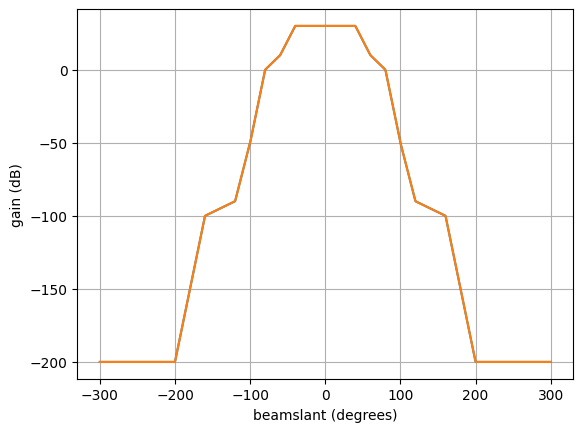

In [3]:
# implementimg the above functions:

# first, gain as a function of azimuthal angle; compare against known values
# use a linear approximation where gain is extrapolated between known points from the datasheet
vert_gain = [(k, v[0], v[1]) for k, v in enumerate(ANT_vert_gain_points)]
horiz_gain = [(k, v[0], v[1]) for k, v in enumerate(ANT_horiz_gain_points)]

def g_lin(theta_rad, gain_f):
    theta_deg_abs = np.abs(np.rad2deg(theta_rad))
    for k, _ in enumerate(gain_f[:-1]):
        a, b = gain_f[k], gain_f[k+1]
        if a[1] <= theta_deg_abs < b[1]:
            dx = theta_deg_abs - a[1]
            dy = (b[2]-a[2]) / (b[1]-a[1]) * dx
            b = a[2]
            return 10**((b+dy)/10)
    return 1

n_pt = 1000
degrees_in = np.linspace(-300, 300, n_pt)
g_out_horiz = np.zeros(n_pt)
g_out_v = np.zeros(n_pt)
for i in range(n_pt):
    g_out_horiz[i] = g_lin(np.deg2rad(degrees_in[i]), horiz_gain)
    g_out_v[i] = g_lin(np.deg2rad(degrees_in[i]), vert_gain)

g_out_db_h = 10*np.log10(g_out_horiz)
g_out_db_v = 10*np.log10(g_out_v)

fig, ax = plt.subplots()
ax.plot(degrees_in, g_out_db_h)
ax.plot(degrees_in, g_out_db_v)

ax.set(xlabel='beamslant (degrees)', ylabel='gain (dB)')
ax.grid()

plt.show()

In [4]:
# with that out of the way, i can now implement some generic functions to calculate the return from an object

def ret_power(gain_f, target_range, target_rcs, target_angle_rad):
    gain = g_lin(target_angle_rad, gain_f)
    pt = ANT_pwr_watt
    gt_gr = gain**2
    return (pt * gt_gr * ANT_lambda**2 * target_rcs) / ((4*math.pi)**3 * target_range**4)

def ret_coeffs(target_range):
    # get coefficients for the return cosine function, constant-phase, frequency
    u = (ANT_f2 - ANT_f1) / ANT_pulse_dur
    delta_t = 2 * target_range / c
    beta = 2*math.pi * ANT_f1 * delta_t - math.pi*u*delta_t**2
    omega = 2*math.pi*u*delta_t
    return beta, omega

def ret_adc_target(t, gain_f, target_range, target_rcs, target_angle_rad):
    # get ADC return value (to be superimposed across targets) at a given time for a single target
    beta, omega = ret_coeffs(target_range)
    power = ret_power(gain_f, target_range, target_rcs, target_angle_rad)
    return power * math.cos(beta + omega * t)

def ret_adc_target_realspace(t, gain_f, target_rcs, target_pos, radar_pos, radar_angle):
    # assume radar angle 0 deg = looking along X axis
    d_crossrange, d_az = (target_pos[0] - radar_pos[0]), (target_pos[1] - radar_pos[1])
    target_angle = math.atan2(d_az, d_crossrange)
    delta_angle = target_angle - radar_angle
    target_dist = math.hypot(d_crossrange, d_az)
    return ret_adc_target(t, gain_f, target_dist, target_rcs, delta_angle)

def ret_adc(t, gain_f, targets, radar_pos, radar_angle):
    v = 0
    for target_pos, target_rcs in targets:
        v += ret_adc_target_realspace(t, gain_f, target_rcs, target_pos, radar_pos, radar_angle)
    return v

def ret_chirp(pulse_duration, fs, gain_f, targets, radar_pos, radar_angle, max_sample_range=-1):
    # return the fast-time slice for a given chirp
    if max_sample_range != -1:
        # range gate the response to decrease bandwidth
        max_time = 2 * max_sample_range / c
        n_samples = int(max_time * fs)
    else:
        n_samples = int(pulse_duration * fs)
    samples = np.zeros(n_samples)
    dtds = pulse_duration / n_samples
    for sample in range(n_samples):
        cur_t = dtds * sample
        samples[sample] = ret_adc(cur_t, gain_f, targets, radar_pos, radar_angle)
    return samples

In [5]:
# we can now simulate a scene and returns.
# e.g. a grid of targets with different reflectivities around 0,0
# targets = [((0, 0), 10), ((0.2, 0.2), 5), ()]
targets = []
for d_crossrange in (-2, 0, 2):
    # for dy in (-0.25, 0, 0.25):
    targets.append(((d_crossrange, 0), 10))
# for d_az in (-2, 2):
#     targets.append(((0, d_az), 10))

# targets = [((0,0), 10)]

radar_angle = np.deg2rad(90)
radar_start_pos = (-4, -4.5) # crossrange, az
radar_vel = (3, 0)
observation_time = 4 # s

path_noise_std = 0
poly_distort = 1

NOISE = False
if NOISE:
    path_noise_std = 0.90 # standard deviation of variance from point-to-point (offset)
    poly_distort = 1.3 # applied to distort overall track to fit a polynomial function

# use "stop-and-go" approximation -- i.e. assume radar is stationary for each sample
PRF = ANT_PRF # from proj proposal -- constrained by minimum movement at given speed
n_sweeps = int(observation_time * PRF)

if ANT_n_pulses is not None:
    n_sweeps = ANT_n_pulses
    PRF = n_sweeps / observation_time

SAR_positions = []

data_matrix = []
for sweep_raw in range(n_sweeps): 
    # calculate radar position
    sweep_polyconv = (sweep_raw/n_sweeps)**poly_distort
    sweep = sweep_polyconv * n_sweeps
    dt = sweep * (1/PRF)

    # offset
    offset_raw = np.random.normal(0, path_noise_std)+1
    dt_offset = dt + (1/PRF) * offset_raw
    dt = dt_offset

    r_pos_local = (
        radar_start_pos[0]+radar_vel[0]*dt,
        radar_start_pos[1]+radar_vel[1]*dt
        ) # crossrange, az
    data_matrix.append(ret_chirp(ANT_pulse_dur, ANT_fs, horiz_gain, targets, r_pos_local, radar_angle, -1))
    SAR_positions.append(r_pos_local)
    if sweep_raw % (n_sweeps//10) == 0:
        # print(r_pos_local)
        print(sweep_raw)

0
20
40
60
80
100
120
140
160
180
200


(201, 400)


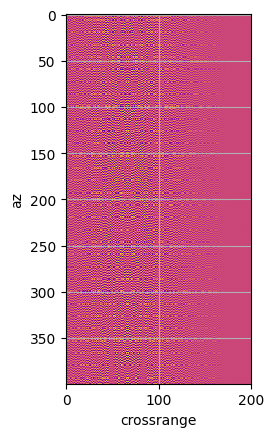

In [6]:
# with some data, now we can do processing. start by plotting data
data_matrix_numpy = np.zeros(shape=(len(data_matrix), len(data_matrix[0]))) # crossrange, az
print(data_matrix_numpy.shape)
for k1, s in enumerate(data_matrix): # crossrange
    for k2 in range(len(data_matrix[0])): # az
        data_matrix_numpy[k1, k2] = s[k2]
fig, ax = plt.subplots()
ax.imshow(data_matrix_numpy[:,:].T, cmap='plasma', interpolation='nearest')
ax.set(xlabel='crossrange', ylabel='az')
# ax.set_aspect(1/(len(data_matrix)/len(data_matrix[0])))
ax.grid()
plt.show()

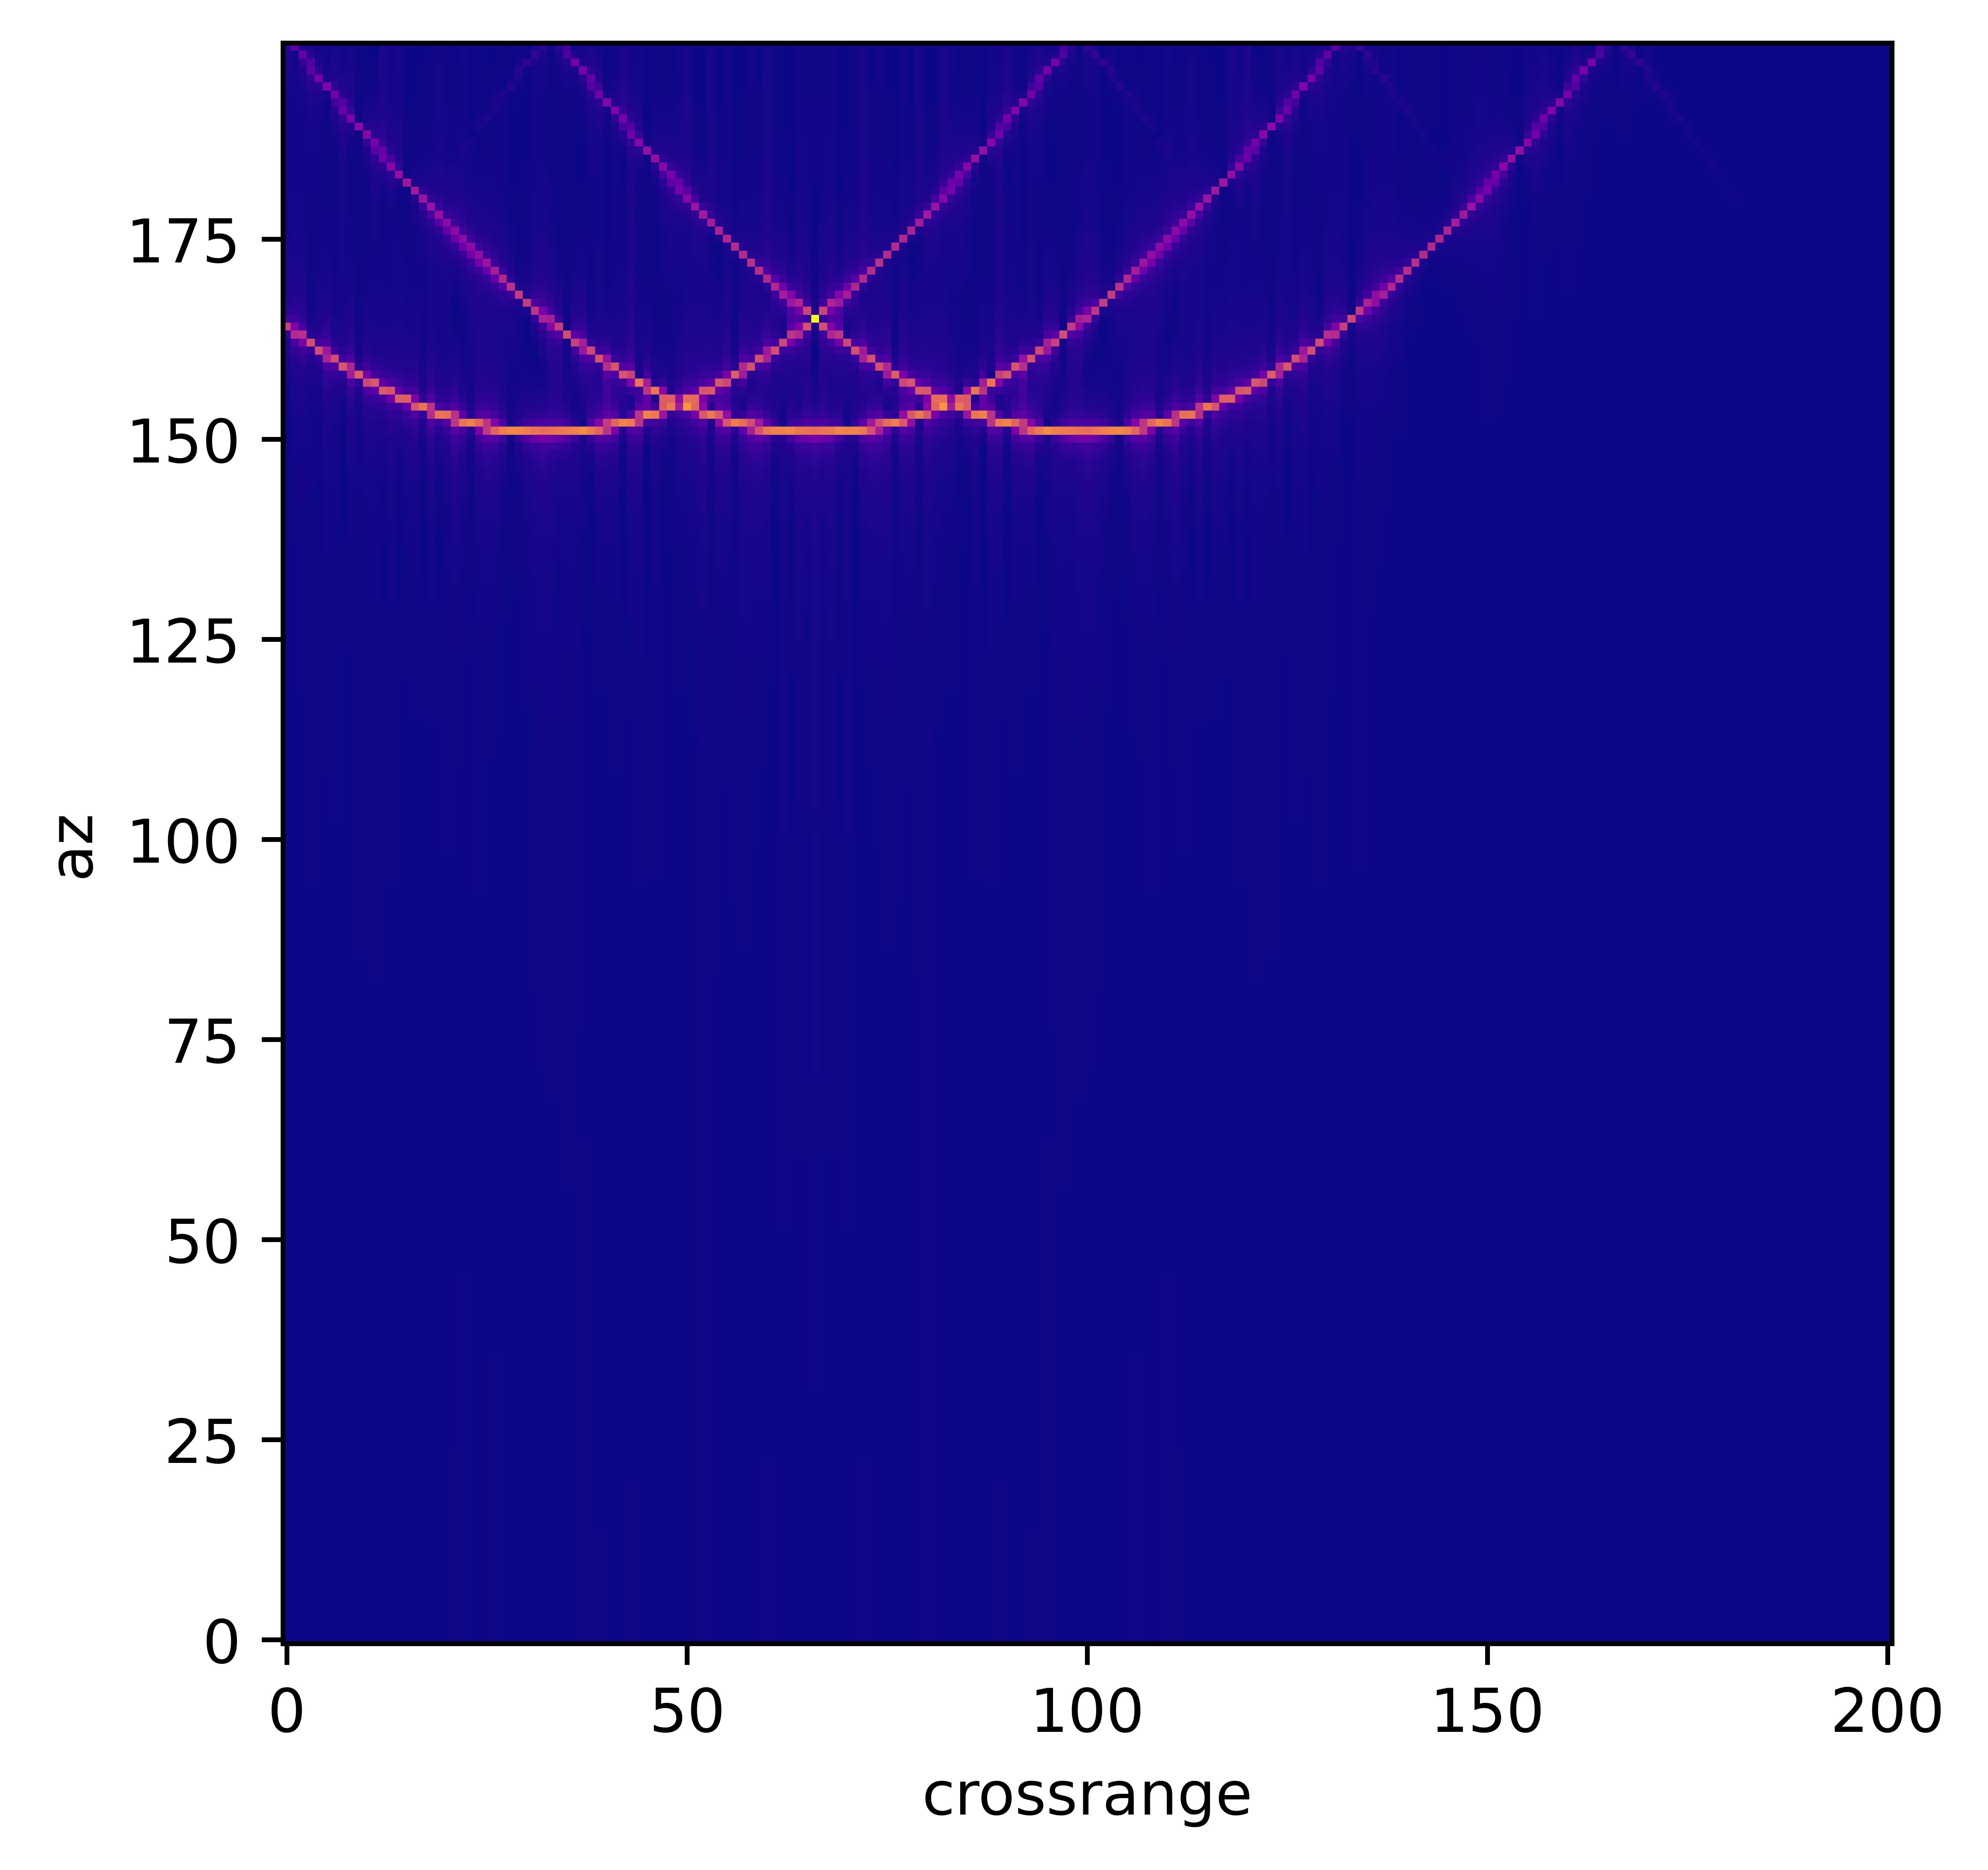

In [7]:
# then, let's attempt range compression
# simply perform an FFT on each fast-time slice and spit out the values
# max_range_gate_m = 4 # for range gating the plot
# max_range_m = c * ANT_pulse_dur / 2 # physical max range for chirp
# print(max_range_m)
# range_res_m = max_range_m / len(data_matrix[0])
# print(len(data_matrix[0]))
# print("range res:", range_res_m)
# max_bin = int((max_range_gate_m // range_res_m) * 2)
# print(max_bin)

# max_bin = int(300)
max_bin = len(data_matrix[0])//2
# max_bin = len(data_matrix[0])

# estimate a noise floor to clamp power
noise_floor = 1.38e-23 * 300 * (ANT_fs) * ANT_NF

fft_vals = np.zeros((len(data_matrix), max_bin))
for idx_crossrange in range(len(data_matrix)):
    fft_out = np.fft.fft(data_matrix_numpy[idx_crossrange], 402)
    for idx_az in range(max_bin):
        v = np.max([np.abs(fft_out[idx_az]), noise_floor])
        # fft_vals[idx_crossrange, idx_az] = 10*np.log10(v)
        fft_vals[idx_crossrange, idx_az] = v
        # fft_vals[fast_time, x] = np.abs(fft_out[x])
fig, ax = plt.subplots()
ax.imshow(fft_vals.T, cmap='plasma', interpolation='nearest')
ax.set(xlabel='crossrange', ylabel='az')
ax.invert_yaxis()
# ax.set_aspect(len(data_matrix)/max_bin)
plt.gcf().set_dpi(1000)
plt.show()
# plt.plot(fft_vals)

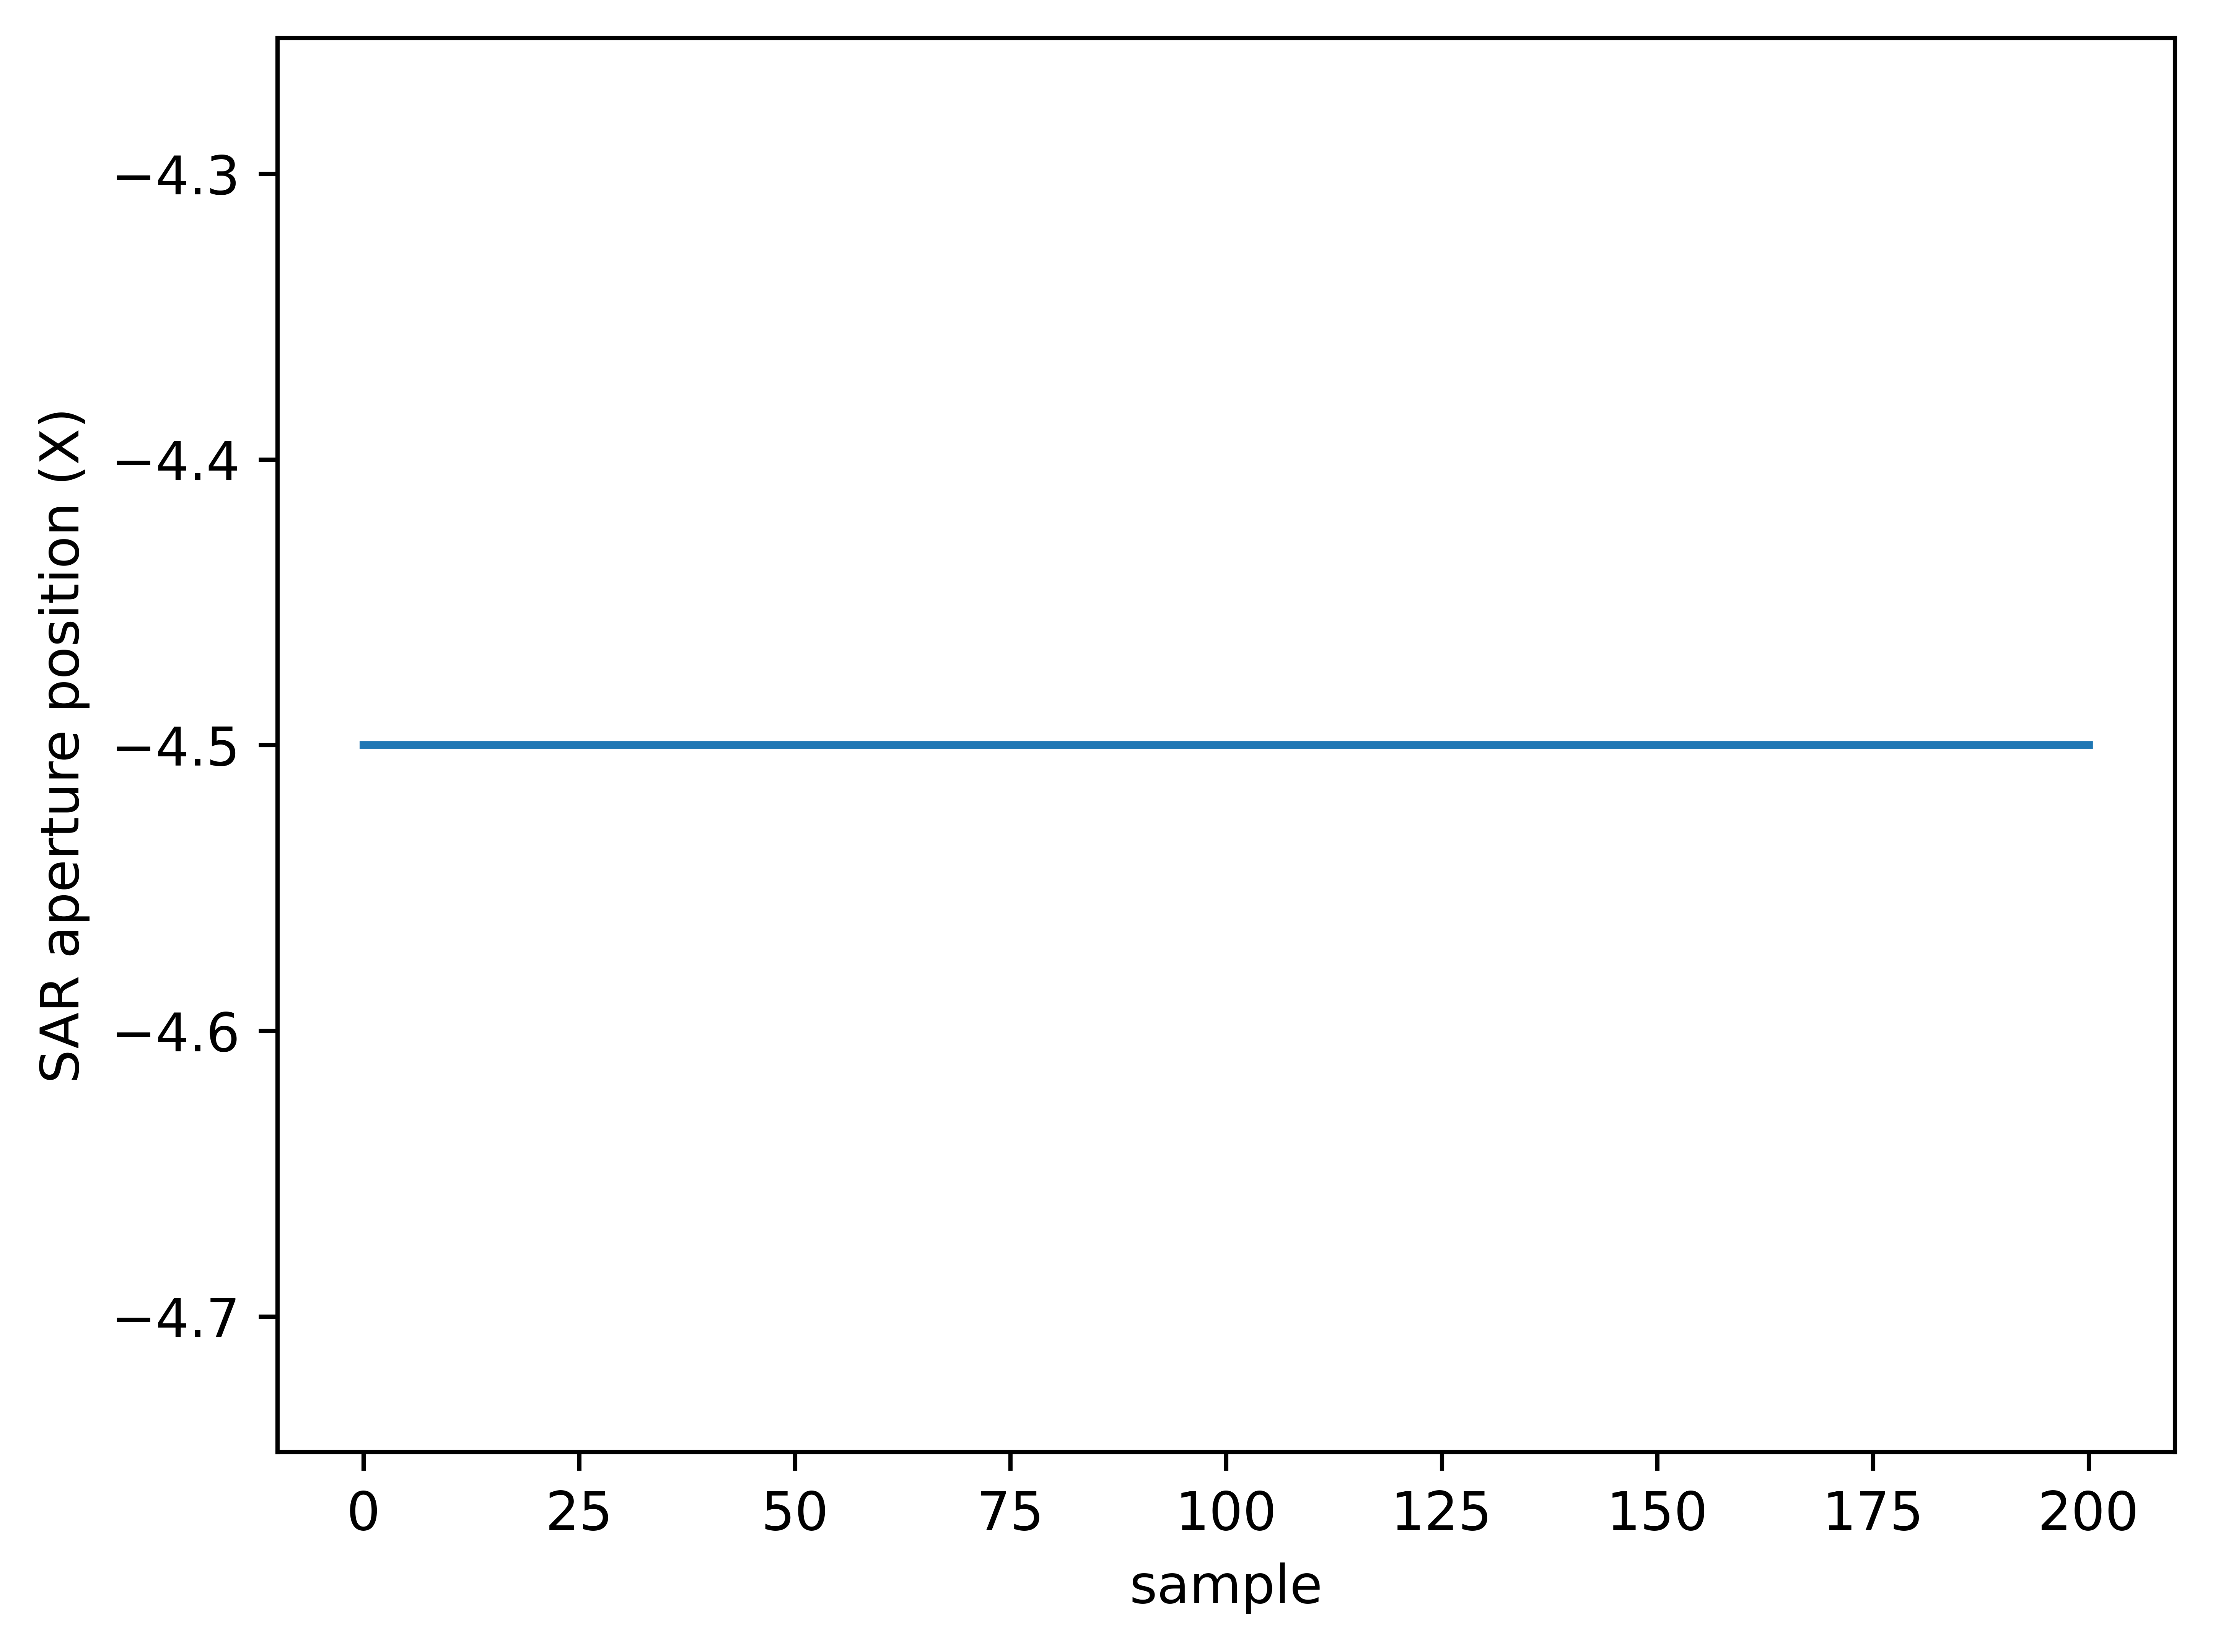

In [8]:
position_track = np.array(SAR_positions)

# print(position_track.T[1])

fig, ax = plt.subplots()
# ax.scatter(*zip(*position_track))
ax.plot(position_track.T[1])
ax.set(xlabel='sample', ylabel='SAR aperture position (X)')
# ax.set_aspect(len(data_matrix)/max_bin)
plt.gcf().set_dpi(1000)
plt.show()

0.0
(201, 200)
4.9123811010525404


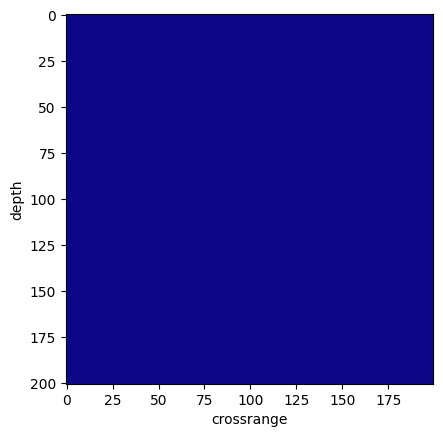

In [9]:
# implement basic backprojection algorithm as described in https://hforsten.com/backprojection-backpropagation.html

# use data_matrix_numpy -- shape of (slow-time, fast-time)
# consider that algorithmic complexity is O(slow-time * fast-time * image-width * image-height) -- very slow!

# add complex component to real-only data via hilbert transform
def hilbert_rvp(x, fs, gamma):
    y = np.fft.fft(x, axis=-1)
    y[:,:y.shape[1]//2+1] = 0
    f = np.linspace(-fs/2, fs/2, y.shape[1])
    y *= np.exp(1j * np.pi * f**2 / gamma)
    return np.fft.ifft(y, axis=-1)

# w = np.hanning(data_matrix_numpy.shape[1])
# data_matrix_hilbert = hilbert_rvp(data_matrix_numpy, ANT_fs, (ANT_f2-ANT_f1) / ANT_pulse_dur)
data_matrix_hilbert = data_matrix_numpy

# essentially, run a matched filtering algorithm on every point in the image

def d_dist(x_vec, p_n_vec):
    # return distance to target at position x from nth sweep at position p_n
    return math.hypot(x_vec[0]-p_n_vec[0], x_vec[1]-p_n_vec[1])

def s_ref(n, m, x_vec, f_pn):
    # for n=slow-time, m=fast-time sample
    # returns complex conjugate of expected IF response -- for matched filtering
    f_c = (ANT_f2 - ANT_f1)/2 + ANT_f1 # center freq of sweep
    gamma = (ANT_f2 - ANT_f1) / (ANT_pulse_dur)
    sampling_interval = 1/(ANT_fs)
    return np.exp(1j * (4*math.pi)/c * (f_c + gamma * m * sampling_interval) * d_dist(x_vec, f_pn(n)))

def radar_path(n):
    dt = n * (1/PRF)
    SAR_tx_pos = (
        radar_start_pos[0] + radar_vel[0] * dt,
        radar_start_pos[1] + radar_vel[1] * dt,
    )
    return SAR_tx_pos

# generate image pixel-by-pixel
# image_az_range = (0, 10) # image pixel range along azimuth (depth from radar) -- relative to radar
# pixel_per_m = 2
depth_range_map = c/(2*ANT_pulse_dur)

# image_az_size = int((image_az_range[1]-image_az_range[0])*pixel_per_m)

# az_positions = np.linspace(image_az_range[0], image_az_range[1], image_az_size)

image_arr = np.zeros((n_sweeps, len(data_matrix[0])//2))

tasks = []

for pulse_n in range(n_sweeps):
    tasks.append((pulse_n))


import multiprocessing
def r_task_img(task):
    slice_arr = np.zeros((1, len(data_matrix[0])//2))
    pulse_n = task
    for depth_y in range(len(data_matrix[0])//2):
        pixel_target_pos = ( # crossrange, depth
            (c / (2*(ANT_f2-ANT_f1))) *depth_y + radar_start_pos[0],
            radar_path(pulse_n)[1],
        )
        s = 0
        data_shape = data_matrix_hilbert.shape
        # for n in range(data_shape[0]):
        #     for m in range(data_shape[1]):
        #         s += data_matrix_hilbert[n, m] * s_ref(n, m, pixel_target_pos, radar_path)
        
        pixel_target_pos = ( # crossrange, depth
            (c / (2*(ANT_f2-ANT_f1))) *depth_y + radar_start_pos[0],
            radar_path(pulse_n)[1],
        )
        s = s_ref(pulse_n, depth_y, (0, 0), radar_path) * data_matrix_hilbert[pulse_n,depth_y]
        
        slice_arr[0, depth_y] = np.real(s)
    return pulse_n, slice_arr


with multiprocessing.Pool(16) as p:
    # slices = p.map(r_task_img, tasks[0:10])
    # slices = p.map(r_task_img, tasks[90:110])
    slices = p.map(r_task_img, tasks)

# for slice_a in slices:
#     pulse_n, slice_arr = slice_a
#     image_arr[pulse_n] = slice_arr

print(np.sum(data_matrix_hilbert[:,:200]*image_arr))
print(image_arr.shape)
print(d_dist((0,0), radar_path(100)))

fig, ax = plt.subplots()
ax.imshow(np.abs(image_arr), cmap='plasma', interpolation='nearest')
# ax.imshow(np.abs(data_matrix_hilbert[:,:200]*image_arr), cmap='plasma', interpolation='nearest')
# ax.imshow(np.abs(data_matrix_hilbert[:,:200]), cmap='plasma', interpolation='nearest')
ax.set(xlabel='crossrange', ylabel='depth')
# ax.set_aspect(x[1]/x[0])
# plt.gcf().set_dpi(150)
plt.show()

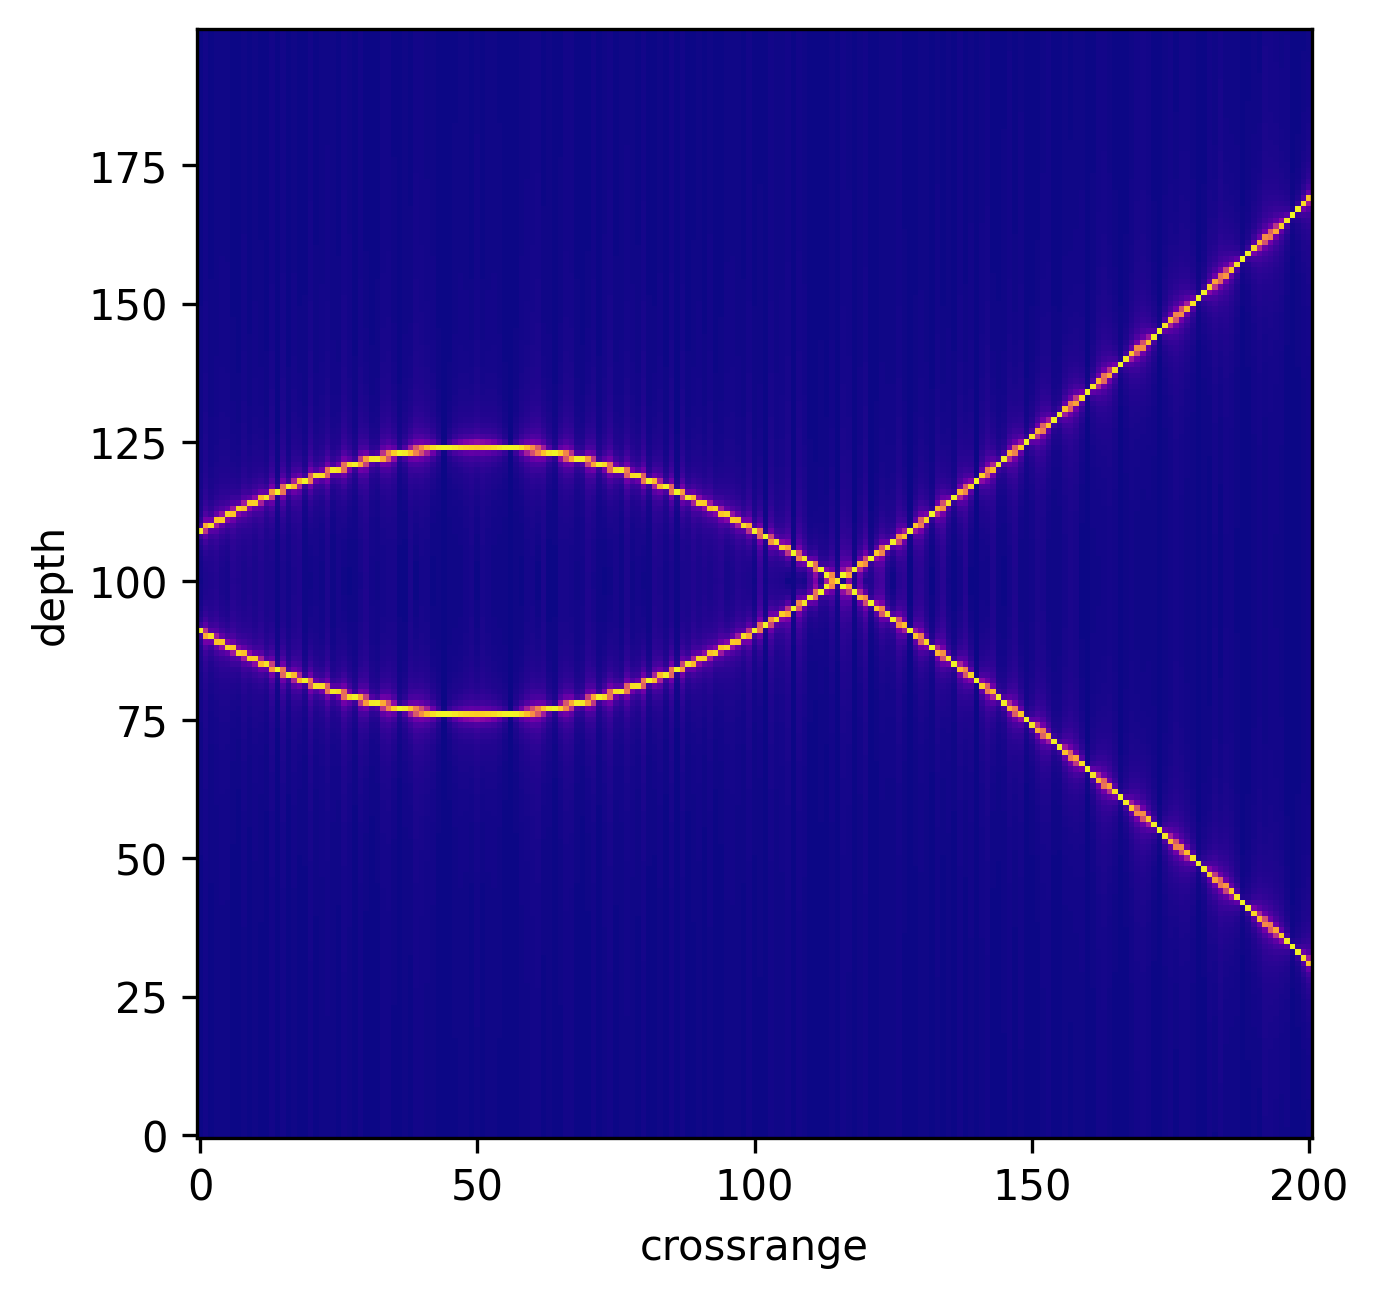

In [12]:
# "optimal" numpy implementation
import torch

# 1) prepare output image matrix
data_matrix_backproj = data_matrix_numpy
# ignore negative bins
data_matrix_backproj = data_matrix_backproj[:,:data_matrix_backproj.shape[1]//2]

out_image = np.zeros(shape=data_matrix_backproj.shape)

# 2) prepare SAR aperture position mapping for later steps, for each slice looking out
# tbd compute more generically
sample_times = np.linspace(0, data_matrix_backproj.shape[0]*(1/PRF), data_matrix_backproj.shape[0]) # TODO use out_image to inform samples
radar_positions_crossrange = np.reshape(sample_times * radar_vel[0] + radar_start_pos[0], shape=(sample_times.shape[0], 1))
radar_positions_az = np.reshape(sample_times * radar_vel[1] + radar_start_pos[1], shape=(sample_times.shape[0], 1))
radar_positions = np.concatenate((radar_positions_crossrange, radar_positions_az), axis=1) # [n]{x,y}

# 3) compute pixel position matrix given above information
# precompute depth transform, apply to radar_positions along crossrange axis
depth_per_pixel = (c / (2*(ANT_f2 - ANT_f1)))
pixel_depths = np.linspace(0, out_image.shape[1], out_image.shape[1])
pixel_depths = np.reshape(pixel_depths, shape=(1, pixel_depths.shape[0]))
pixel_depths *= depth_per_pixel
pixel_positions_az = radar_positions_az+pixel_depths # precomputed azimuthal depths

# compute matrices with radar, pixel world positions for each sampled data point [n][m][x,y] for n=crosscrange, m=az
# x is crossrange, y is az
radar_position_image = np.ones(shape=[data_matrix_backproj.shape[0], data_matrix_backproj.shape[1], 2])
pixel_position_image = np.ones(shape=radar_position_image.shape)
for m in range(data_matrix_backproj.shape[1]):
    for n in range(data_matrix_backproj.shape[0]):
        radar_position_image[n][m] = radar_positions[n]
        pixel_position_image[n][m][0] = radar_position_image[n][m][0]
        pixel_position_image[n][m][1] = pixel_positions_az[n][m]

# 4) compute matched filter for each pixel position (TODO assuming that pixel space and sample space line up via M)
f_center = (ANT_f2 - ANT_f1)/2 + ANT_f1
lfm_gamma = (ANT_f2 - ANT_f1) / (ANT_pulse_dur)
adc_sampling_interval = 1/(ANT_fs)
def filter_for_sample(n, m):
    # point on img
    pixel_pos = pixel_position_image[n,m]
    radar_dists = pixel_pos[0]-radar_position_image[:,:,0], pixel_pos[1]-radar_position_image[:,:,1]
    radar_dists = np.hypot(radar_dists[0], radar_dists[1])
    # print(np.min(radar_dists))
    # print(np.max(radar_dists))
    # print(radar_dists)
    depth_y = np.linspace(0, data_matrix_backproj.shape[1], data_matrix_backproj.shape[1])
    filter_img = np.zeros(shape=data_matrix_backproj.shape)
    filter_img = np.exp(1j * (4*np.pi)/c * (f_center + lfm_gamma * adc_sampling_interval * depth_y) * radar_dists)

    return filter_img

# potentially compute all of the filters in parallel and do the tensor dot product to reduce at the end

# for n in range(out_image.shape[0]):
#     for m in range(out_image.shape[1]):
#         filt = filter_for_sample(n, m)
#         out_image[n][m] = np.real(np.tensordot(filt, data_matrix_backproj))
#     print(n)
# x = out_image

x = np.real(filter_for_sample(50, 150))
x = np.fft.fft(x)
# x = np.fft.fft(data_matrix_backproj)

fig, ax = plt.subplots()
ax.imshow(np.abs(x).T, cmap='plasma', interpolation='nearest')
ax.set(xlabel='crossrange', ylabel='depth')
ax.invert_yaxis()
# ax.set_aspect(x[1]/x[0])
plt.gcf().set_dpi(300)
plt.show()

(201, 200)


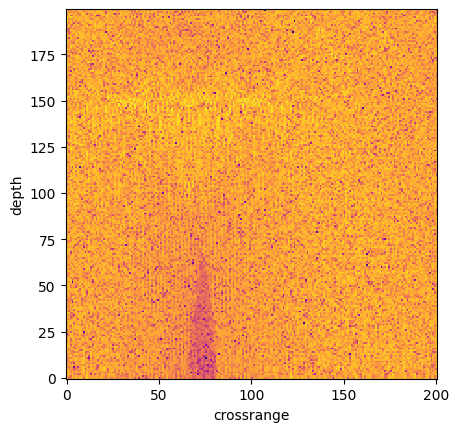

In [11]:
image_arr = out_image
s = image_arr.shape
# fig, ax = plt.subplots()
# ax.imshow(10*np.log10(data_matrix_numpy), cmap='plasma', interpolation='nearest')
# ax.imshow(np.abs(data_matrix_hilbert), cmap='plasma', interpolation='nearest')

dd = image_arr
print(dd.shape)
fft_vals = np.zeros((dd.shape[0], dd.shape[1]))
for idx_crossrange in range(fft_vals.shape[0]):
    fft_out = np.fft.fft(dd[idx_crossrange])
    for idx_az in range(fft_vals.shape[1]):
        fft_vals[idx_crossrange, idx_az] = np.real(fft_out[idx_az])

# ax.imshow(10*np.log10(np.abs(image_arr)), cmap='plasma', interpolation='nearest')
# ax.imshow(np.abs(image_arr), cmap='plasma', interpolation='nearest')
# ax.set(xlabel='depth', ylabel='crossrange')
# ax.set_aspect(s[1]/s[0])
# plt.gcf().set_dpi(150)
# plt.show()
fig, ax = plt.subplots()
ax.imshow(10*np.log10(np.abs(x)).T, cmap='plasma', interpolation='nearest')
ax.set(xlabel='crossrange', ylabel='depth')
ax.invert_yaxis()
# ax.set_aspect(x[1]/x[0])
# plt.gcf().set_dpi(150)
plt.show()